# Frequency-switched Data Reduction
-----------------------------------

This notebook shows how to use `dysh` to calibrate a frequency switched observations. The idea is similar to an OnOff observation, except the telescope does not move to an Off in position, but move their IF in frequency space. Here we call the On/Off the Sig and Ref. Since the telescope observes in a Track mode, combining the sig and a shifted (folded) ref, a $\sqrt{2}$ improvement in S/N can be achieved.

It retrieves and calibrates frequency-switched scans using `GBTFITSLoad.getfs()`, which returns a `ScanBlock` object.  

In [9]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
import dysh.util as util
import numpy as np

## First, we download the example SDFITS data, if necessary.


In [2]:
# just scan6 
filename = "AGBT20B_014_03.raw.vegas.A6.fits"
if not os.path.isfile(filename):
    url = f"http://www.gb.nrao.edu/dysh/example_data/onoff-L/data/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded")

HTTPError: HTTP Error 404: Not Found

In [5]:
filename = util.get_project_testdata()/"AGBT20B_014_03.raw.vegas/AGBT20B_014_03.raw.vegas.A6.fits"

In [6]:
sdfits = GBTFITSLoad(filename)
sdfits.info()
sdfits.summary()

Filename: /home/mpound/src/dysh/testdata/AGBT20B_014_03.raw.vegas/AGBT20B_014_03.raw.vegas.A6.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  SINGLE DISH    1 BinTableHDU    185   88R x 83C   ['32A', 'D', '22A', 'D', 'D', 'D', '16384E', '16A', '6A', '8A', 'D', 'D', 'D', '4A', 'D', '4A', 'D', 'I', '32A', '32A', 'J', '32A', '16A', 'D', '8A', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', '8A', 'D', 'D', '8A', 'I', 'I', 'D', 'D', 'I', 'A', 'I', 'I', '16A', '16A', 'J', 'J', '22A', 'D', 'D', 'I', 'A', 'D', 'D', 'E', 'D', 'D', 'D', 'D', 'A', 'A', '8A', 'E', 'E', '16A', '32A', '32A', '32A', 'D', 'D', 'D', 'I', 'I', 'I', 'J', 'J']   


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,M33S,0.0,Track,1,1.595789,1.420405,4,2,3,1,72.213498,28.201934


In [7]:
#fsscan = sdfits.getfs(6, ifnum=0, plnum=1)
#    why does this not work, where getps(6) would work???
#
# Answer: getps(6) is no longer correct either.  This was a change when selection was implemented, scan is now a kwarg not a default argument.
fsscan = sdfits.getfs(scan=6, ifnum=0, plnum=1)
fsscan.calibrate()

{'scan': 6, 'ifnum': 0, 'plnum': 1}
Calibrated 3 spectra with fold=True and use_sig=True
Calibrated 3 spectra with fold=False and use_sig=True


In [10]:

print(f"T_sys = {np.nanmean(fsscan[0].tsys):.2f}")

T_sys = 18.11


In [11]:
ta = fsscan.timeaverage(weights='tsys')

PJT:   timeaverage


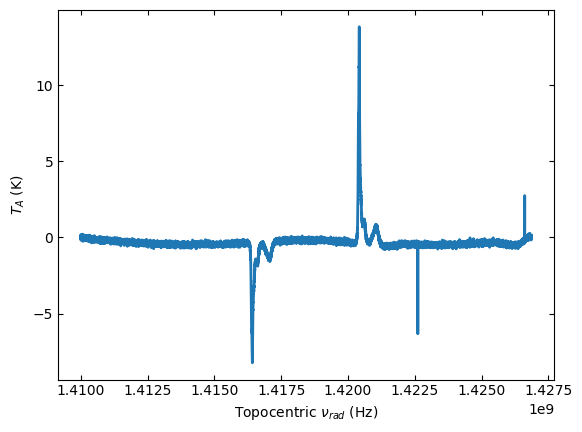

In [12]:
ta.plot()

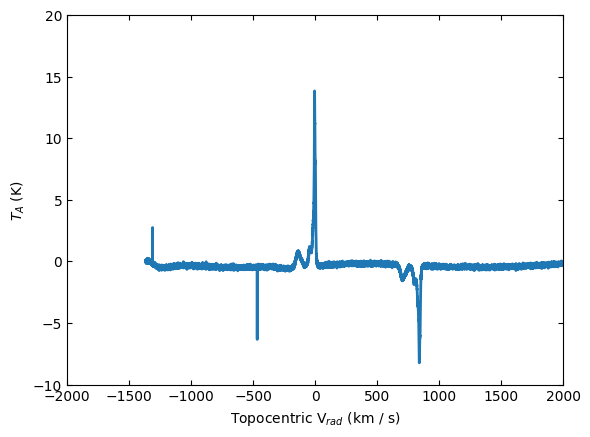

In [13]:
ta.plot(xaxis_unit="km/s",yaxis_unit="K",ymin=-10,ymax=20,xmin=-2000,xmax=2000)

In [16]:
kms = u.km/u.s
#ta.baseline(degree=2,exclude=[(-2000*kms,-400*kms),(-200*kms,100*kms),(600*kms,3000*kms)],remove=True)
ta.baseline(degree=2,exclude=[-200*kms,100*kms],remove=True)

# @todo  we really should have an include= option as well, mutually exclusive

EXCLUDING [Spectral Region, 1 sub-regions:
  (1419929945.1210444 Hz, 1421351333.4469643 Hz) 
]


 [astropy.modeling.fitting]


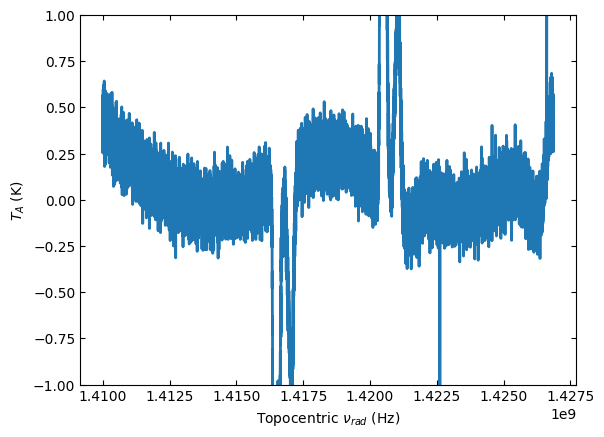

In [17]:
ta.plot(ymin=-1,ymax=1)

In [18]:
print(ta.baseline_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
              c0                     c1                      c2          
              K                    K / Hz                 K / Hz2        
    ---------------------- ---------------------- -----------------------
    -8.882452439800267e-17 -3.113706564831629e-44 -1.0914002601893674e-71


In [19]:
ta.savefig("baselined_removed.png")

In [22]:
help(ta.baseline)

Help on method baseline in module dysh.spectra.spectrum:

baseline(degree, exclude=None, **kwargs) method of dysh.spectra.spectrum.Spectrum instance
    Compute and optionally remove a baseline.  The model for the
    baseline can be either a
    `1D polynomial model <https://docs.astropy.org/en/latest/api/astropy.modeling.polynomial.Polynomial1D.html>`_ or a
    `1D Chebyshev polynomial of the first kind <https://docs.astropy.org/en/latest/api/astropy.modeling.polynomial.Chebyshev1D.html>`_.
    The code uses `astropy.modeling`
    and `astropy.fitter` to compute the baseline.  See the documentation for those modules.
    This method will set the `baseline_model` attribute to the fitted model function which can be evaluated over a domain.
    
    Parameters
    ----------
        degree : int
            The degree of the polynomial series, a.k.a. baseline order
        exclude : list of 2-tuples of int or ~astropy.units.Quantity, or ~specutils.SpectralRegion
            List of regi

In [23]:
from specutils import SpectralRegion

In [25]:
SpectralRegion([(10*u.km/u.s,20*u.km/u.s)])

Spectral Region, 1 sub-regions:
  (10.0 km / s, 20.0 km / s) 

In [26]:
ta.baseline(degree=2,exclude=SpectralRegion([(-2000*kms,-400*kms),(-200*kms,100*kms),(600*kms,3000*kms)]),remove=True)

AttributeError: 'NotImplementedType' object has no attribute 'dtype'

In [38]:
sr =SpectralRegion([(-2000*kms,-400*kms),(-200*kms,100*kms),(600*kms,3000*kms)])
sr2 = SpectralRegion([(-2000*kms,-400*kms)])

In [39]:
ta.baseline(exclude=sr2,degree=2)

AttributeError: 'NotImplementedType' object has no attribute 'dtype'

In [30]:
sr.__dict__

{'_subregions': [(<Quantity -2000. km / s>, <Quantity -400. km / s>),
  (<Quantity -200. km / s>, <Quantity 100. km / s>),
  (<Quantity 600. km / s>, <Quantity 3000. km / s>)]}

In [41]:
sr.bounds[0] < ta.spectral_axis[0]

AttributeError: 'NotImplementedType' object has no attribute 'dtype'